In [32]:
import polars as pl
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
commission = 0.25 / 10000.0

In [33]:
from datetime import timedelta

def aggregate_to_weekly(input_df, start_day_of_week):
    day_names = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
    print(f"Aggregating daily bar to weekly, start from {day_names[start_day_of_week]}")

    def adjust_date(date):
        # Calculate the number of days to subtract to make 'start_day_of_week' the beginning of the week
        # We need to adjust the index by -1 since Python's weekday() returns Monday as 0, not 1
        weekday = date.dt.weekday()  # Monday is 0, Sunday is 6
        days_to_subtract = (weekday - (start_day_of_week - 1)) % 7
        return date - pl.duration(days=days_to_subtract)

    # Apply the adjustment to 'open_time'
    input_df = input_df.with_columns(
        adjust_date(pl.col("open_time")).alias("open_time")
    )

    # Group by 'symbol' and the adjusted week_start, then aggregate the columns
    weekly_df = input_df.groupby(["symbol", "open_time"]).agg([
        pl.col("open").first().alias("open"),     # Open of the first day in the week
        pl.col("high").max().alias("high"),       # Maximum high in the week
        pl.col("low").min().alias("low"),         # Minimum low in the week
        pl.col("close").last().alias("close"),   # Close of the last day in the week
        pl.col("close_time").last().alias("close_time"),
        pl.col("volume").sum().alias("volume"),  # Sum of volume in the week
        pl.col("quote_volume").sum().alias("quote_volume"), # Sum of quote_volume
        pl.col("count").sum().alias("count"),    # Sum of count
        pl.col("taker_buy_volume").sum().alias("taker_buy_volume"), # Sum of taker_buy_volume
        pl.col("taker_buy_quote_volume").sum().alias("taker_buy_quote_volume") # Sum of taker_buy_quote_volume
    ])

    return weekly_df

In [34]:
if 1:
    input_df = pl.read_parquet("data/kline_1d_df.parquet")
    input_df = input_df.rename({"jj_code": "symbol"})
else:
    input_df = pl.read_parquet("data/daily_data.pa")

input_df = input_df.sort(['symbol', 'open_time'])


# # MA 10
# calc_factor = input_df.groupby('symbol').apply(
#     lambda df: df.with_columns(
#         (pl.col('close').rolling_mean(window_size=10)).alias('factor')
#         # (pl.col('close')).alias('factor')
#     )
# )

# # the return in the past 3 bar
# calc_factor = input_df.groupby('symbol').apply(
#     lambda df: df.with_columns(
#         # Calculate the return percentage compared to 10 time slices ago
#         ((pl.col('close') / pl.col('close').shift(3) - 1) * 100).alias('factor')
#     )
# )

# input_df = input_df.with_columns(
#     ((pl.col('close') / pl.col('close').shift(1) - 1) * 100).alias('return')
# )

input_df = input_df.sort(["symbol", "open_time"])
input_column_name = input_df.columns

print (input_df.columns)

AGG_TO_WEEK = 0

if AGG_TO_WEEK:
    input_df = aggregate_to_weekly(input_df, 1)
    assert sorted(input_df.columns) == sorted(input_column_name), f'before aggregate to week {sorted(input_column_name)}, but after is {sorted(input_df.columns)}' # the column should be the same
    input_df = input_df.sort(["symbol", "open_time"])

input_df


# 千万注意，这里是计算此时刻相对于前一时刻的return，不能使用未来信息 -> shift(1)是整体往下移动
input_df = input_df.with_columns(
    ((pl.col("close") / pl.col("close").shift(1) - 1) * 100)
    .over("symbol")  # Applying the function over each symbol group
    .alias("return")
).fill_null (0)


input_df = input_df.with_columns(
    pl.col("return").abs().rolling_sum(window_size=10).over("symbol").alias("rolling_abs_return_sum"),
    pl.col("quote_volume").rolling_sum(window_size=10).over("symbol").alias("rolling_quote_volume_sum")
)

input_df = input_df.with_columns(
    (pl.col("rolling_abs_return_sum") / pl.col("rolling_quote_volume_sum"))
    .over("symbol")  # Apply the final operation within each symbol group
    .alias("amihud")
).fill_null(0)

input_df = input_df.drop(["rolling_abs_return_sum", "rolling_volume_sum"])

input_df

['symbol', 'open_time', 'close_time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume']


shape: (230_723, 15)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ symbol    ┆ open_time ┆ close_tim ┆ open     ┆ … ┆ taker_buy ┆ return    ┆ rolling_q ┆ amihud    │
│ ---       ┆ ---       ┆ e         ┆ ---      ┆   ┆ _quote_vo ┆ ---       ┆ uote_volu ┆ ---       │
│ str       ┆ datetime[ ┆ ---       ┆ f64      ┆   ┆ lume      ┆ f64       ┆ me_sum    ┆ f64       │
│           ┆ ms]       ┆ datetime[ ┆          ┆   ┆ ---       ┆           ┆ ---       ┆           │
│           ┆           ┆ ms]       ┆          ┆   ┆ f64       ┆           ┆ f64       ┆           │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1000BONKU ┆ 2023-11-2 ┆ 2023-11-2 ┆ 0.00478  ┆ … ┆ 2.7467e7  ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ SDT       ┆ 2         ┆ 2 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ 1000BONKU ┆ 2023-11-2 ┆ 2023-11-2 ┆ 0.004531 ┆ … ┆ 3.8318e7  ┆ -5.826528 ┆ 0.0       ┆ 0.0       │
│ SDT       ┆ 3         ┆ 3 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ 1000BONKU ┆ 2023-11-2 ┆ 2023-11-2 ┆ 0.004267 ┆ … ┆ 3.2393e7  ┆ -2.97633  ┆ 0.0       ┆ 0.0       │
│ SDT       ┆ 4         ┆ 4 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ 1000BONKU ┆ 2023-11-2 ┆ 2023-11-2 ┆ 0.004143 ┆ … ┆ 2.7819e7  ┆ 4.830918  ┆ 0.0       ┆ 0.0       │
│ SDT       ┆ 5         ┆ 5 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ 1000BONKU ┆ 2023-11-2 ┆ 2023-11-2 ┆ 0.004341 ┆ … ┆ 1.5980e7  ┆ -6.935484 ┆ 0.0       ┆ 0.0       │
│ SDT       ┆ 6         ┆ 6 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …         ┆ …         ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ ZRXUSDT   ┆ 2024-07-3 ┆ 2024-07-3 ┆ 0.3687   ┆ … ┆ 1.2168e7  ┆ -0.949281 ┆ 1.4854e8  ┆ 2.0855e-7 │
│           ┆ 1         ┆ 1 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ ZRXUSDT   ┆ 2024-08-0 ┆ 2024-08-0 ┆ 0.3652   ┆ … ┆ 9.6720e6  ┆ -4.353779 ┆ 1.6106e8  ┆ 1.8871e-7 │
│           ┆ 1         ┆ 1 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ ZRXUSDT   ┆ 2024-08-0 ┆ 2024-08-0 ┆ 0.3492   ┆ … ┆ 7.4088e6  ┆ -9.476095 ┆ 1.5871e8  ┆ 2.5055e-7 │
│           ┆ 2         ┆ 2 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ ZRXUSDT   ┆ 2024-08-0 ┆ 2024-08-0 ┆ 0.3163   ┆ … ┆ 7.0421e6  ┆ -3.383934 ┆ 1.6561e8  ┆ 2.4208e-7 │
│           ┆ 3         ┆ 3 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
│ ZRXUSDT   ┆ 2024-08-0 ┆ 2024-08-0 ┆ 0.3055   ┆ … ┆ 4.7896e6  ┆ -5.630115 ┆ 1.6465e8  ┆ 2.6090e-7 │
│           ┆ 4         ┆ 4 23:59:5 ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ 00:00:00  ┆ 9.999     ┆          ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [35]:
import polars as pl
import numpy as np
from scipy.stats import kendalltau, skew, kurtosis, spearmanr


def calc_auto_kendall_corr(df: pl.DataFrame, result_column_name = 'return_auto_corr', lag_list: list = [1]) -> pl.DataFrame:
    input_list = df['return'].to_list()
    n = len(input_list)
    auto_corr_pearson = [[] for _ in range(len(lag_list))]
    auto_corr_spearman = [[] for _ in range(len(lag_list))]
    auto_corr_kendall = [[] for _ in range(len(lag_list))]
    running_skewness = []
    running_kurtosis = []

    # print (lag_list, len (lag_list))
    # print ('before start: ', len (auto_corr_pearson), len (auto_corr_spearman), len (auto_corr_kendall))
    
    for i in range(0, n):
        for lag_index, lag in enumerate(lag_list):
            # print ('i: ', i, '  lag_index: ', lag_index, '  lag: ', lag)
            # calc kendall tau auto_corr
            if i < lag:
                # auto_corr.append(np.nan)
                auto_corr_pearson[lag_index].append(np.nan)
                auto_corr_spearman[lag_index].append(np.nan)
                auto_corr_kendall[lag_index].append(np.nan)
            else:
                # print ('==== not NaN')
                a = input_list[lag:i + 1]
                b = input_list[0 : i + 1 - lag]

                auto_corr_pearson[lag_index].append(np.corrcoef(a, b)[0, 1])
                auto_corr_spearman[lag_index].append(spearmanr(a, b)[0])
                auto_corr_kendall[lag_index].append(kendalltau(a, b)[0])


        # calc skew
        current_skewness = skew(input_list[:i], bias=False) if i > 2 else np.nan  # skew requires at least 3 values to compute
        running_skewness.append(current_skewness)

        # calc kurtosis
        current_kurtosis = kurtosis(input_list[:i], bias=False) if i > 2 else np.nan  # kurtosis also requires at least 3 values
        running_kurtosis.append(current_kurtosis)
    
    # print (f'input: {df.shape} ===  skew {len(running_skewness)} == kurtosis {len(running_kurtosis)}')
    # for i in range(len(lag_list)):
    #     print (f'lag {lag_list[i]} === pearson {len(auto_corr_pearson[i])} == spearman {len(auto_corr_spearman[i])} == kendall {len(auto_corr_kendall[i])}')

    assert len (lag_list) == len (auto_corr_pearson) == len (auto_corr_spearman) == len (auto_corr_kendall), f'lag_list: {len(lag_list)} == auto_corr_pearson: {len(auto_corr_pearson)} == auto_corr_spearman: {len(auto_corr_spearman)} == auto_corr_kendall: {len(auto_corr_kendall)}'

    # auto_corr_series = [
    #     pl.Series(name=f'{result_column_name}_pearson_lag{lag}', values = cur_auto_corr_pearson),
    #     pl.Series(name=f'{result_column_name}_sprearman_lag{lag}', values = cur_auto_corr_sprearman),
    #     pl.Series(name=f'{result_column_name}_kendall_lag{lag}', values = cur_auto_corr_kendall)
    #     for lag, cur_auto_corr_pearson, cur_auto_corr_sprearman, cur_auto_corr_kendall in zip(lag_list, auto_corr_pearson, auto_corr_spearman, auto_corr_kendall)
    # ]

    # auto_corr_series = [
    # pl.Series(name=f'{result_column_name}_pearson_lag{lag}', values = auto_corr_pearson[lag_index])
    # # pl.Series(name=f'{result_column_name}_spearman_lag{lag}', values = auto_corr_spearman[lag_index]),
    # # pl.Series(name=f'{result_column_name}_kendall_lag{lag}', values = auto_corr_kendall[lag_index])
    # for lag_index, lag in enumerate(lag_list)
    # ]

    auto_corr_series = [
    series
    for lag_index, lag in enumerate(lag_list)
        for series in [
            pl.Series(name=f'{result_column_name}_pearson_lag{lag}', values=auto_corr_pearson[lag_index]),
            pl.Series(name=f'{result_column_name}_spearman_lag{lag}', values=auto_corr_spearman[lag_index]),
            pl.Series(name=f'{result_column_name}_kendall_lag{lag}', values=auto_corr_kendall[lag_index])
        ]
    ]

    additional_series = [
        pl.Series(name='return_skew', values=running_skewness),
        pl.Series(name='return_kurtosis', values=running_kurtosis)
    ]

    return df.with_columns (auto_corr_series + additional_series)

## Calc auto_corr for 'return' column

In [40]:
import os
LOAD_FILE_NO_CALC = 1
result_hour_path = 'data/result_hour.parquet'
# result_hour_path = 'data/linear_predicted_returns.parquet'

if LOAD_FILE_NO_CALC:
    if os.path.exists(result_hour_path):
        result_hour = pl.read_parquet(result_hour_path)
    else:
        assert 0, 'miss file'
else:
    result_hour = input_df.clone()
    result_hour = result_hour.groupby("symbol").apply(lambda group: calc_auto_kendall_corr(group,  'return_auto_corr_1', lag_list=[1, 2, 5, 10]))
    result_hour.write_parquet(result_hour_path)

result_hour

shape: (230_723, 29)
┌──────────┬────────────┬────────────┬────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ symbol   ┆ open_time  ┆ close_time ┆ open   ┆ … ┆ return_aut ┆ return_au ┆ return_sk ┆ return_ku │
│ ---      ┆ ---        ┆ ---        ┆ ---    ┆   ┆ o_corr_1_s ┆ to_corr_1 ┆ ew        ┆ rtosis    │
│ str      ┆ datetime[m ┆ datetime[m ┆ f64    ┆   ┆ pearman_la ┆ _kendall_ ┆ ---       ┆ ---       │
│          ┆ s]         ┆ s]         ┆        ┆   ┆ g1…        ┆ lag10     ┆ f64       ┆ f64       │
│          ┆            ┆            ┆        ┆   ┆ ---        ┆ ---       ┆           ┆           │
│          ┆            ┆            ┆        ┆   ┆ f64        ┆ f64       ┆           ┆           │
╞══════════╪════════════╪════════════╪════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ EGLDUSDT ┆ 2020-09-14 ┆ 2020-09-14 ┆ 13.294 ┆ … ┆ NaN        ┆ NaN       ┆ NaN       ┆ NaN       │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ EGLDUSDT ┆ 2020-09-15 ┆ 2020-09-15 ┆ 13.997 ┆ … ┆ NaN        ┆ NaN       ┆ NaN       ┆ NaN       │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ EGLDUSDT ┆ 2020-09-16 ┆ 2020-09-16 ┆ 13.04  ┆ … ┆ NaN        ┆ NaN       ┆ NaN       ┆ NaN       │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ EGLDUSDT ┆ 2020-09-17 ┆ 2020-09-17 ┆ 12.578 ┆ … ┆ NaN        ┆ NaN       ┆ 0.388318  ┆ -1.5      │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ EGLDUSDT ┆ 2020-09-18 ┆ 2020-09-18 ┆ 12.061 ┆ … ┆ NaN        ┆ NaN       ┆ 0.773632  ┆ 1.608859  │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ …        ┆ …          ┆ …          ┆ …      ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ STGUSDT  ┆ 2024-07-31 ┆ 2024-07-31 ┆ 0.3639 ┆ … ┆ -0.020268  ┆ -0.014525 ┆ 1.694803  ┆ 13.817672 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ STGUSDT  ┆ 2024-08-01 ┆ 2024-08-01 ┆ 0.3563 ┆ … ┆ -0.018891  ┆ -0.013566 ┆ 1.697026  ┆ 13.8379   │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ STGUSDT  ┆ 2024-08-02 ┆ 2024-08-02 ┆ 0.3494 ┆ … ┆ -0.016344  ┆ -0.011847 ┆ 1.69923   ┆ 13.858619 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ STGUSDT  ┆ 2024-08-03 ┆ 2024-08-03 ┆ 0.329  ┆ … ┆ -0.015518  ┆ -0.01122  ┆ 1.698764  ┆ 13.836453 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
│ STGUSDT  ┆ 2024-08-04 ┆ 2024-08-04 ┆ 0.3188 ┆ … ┆ -0.014108  ┆ -0.010243 ┆ 1.700922  ┆ 13.849544 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆           ┆           ┆           │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆           ┆           ┆           │
└──────────┴────────────┴────────────┴──

### Add alpha101 factor

In [41]:
from scipy.stats import rankdata


def CalcAlpha101Factor(result_hour: pl.DataFrame, window_size=10) -> pl.DataFrame:
    window_size = 10  # Example window size

    # 移动求和
    def ts_sum(df, window):
        return df.rolling(window).sum()

    # 移动平均
    def sma(df, window):
        return df.rolling(window).mean()

    # 移动标准差
    def stddev(df, window):
        return df.rolling(window).std()

    # 移动相关系数
    def correlation(x, y, window):
        return x.rolling(window).corr(y)

    # 移动协方差
    def covariance(x, y, window):
        return x.rolling(window).cov(y)

    # 在过去d天的时序排名
    def rolling_rank(na):
        return rankdata(na)[-1]

    def ts_rank(df, window):
        return df.rolling(window).apply(rolling_rank)

    # 过去d天的时序乘积
    def rolling_prod(na):
        return np.prod(na)

    def product(df, window):
        return df.rolling(window).apply(rolling_prod)

    # 过去d天最小值
    def ts_min(df, window):
        return df.rolling(window).min()

    # 过去d天最大值
    def ts_max(df, window):
        return df.rolling(window).max()

    # 当天取值减去d天前的值
    def delta(df, period):
        return df.diff(period)

    # d天前的值，滞后值
    def delay(df, period):
        return df.shift(period)

    # 截面数据排序，输出boolean值
    import pandas as pd

    def rank(df):
        if isinstance(df, pd.DataFrame):
            return df.rank(pct=True, axis=1)
        else:
            assert type(df) == pd.Series
            return df.rank(pct=True)

    # 缩放时间序列，使其和为1
    def scale(df, k=1):
        return df.mul(k).div(np.abs(df).sum())

    # 过去d天最大值的位置
    def ts_argmax(df, window):
        return df.rolling(window).apply(np.argmax) + 1

    # 过去d天最小值的位置
    def ts_argmin(df, window):
        return df.rolling(window).apply(np.argmin) + 1

    # 线性衰减的移动平均加权
    def decay_linear(df, period):
        if df.isnull().values.any():
            df.fillna(method="ffill", inplace=True)
            df.fillna(method="bfill", inplace=True)
            df.fillna(value=0, inplace=True)
        na_lwma = np.zeros_like(df)  # 生成与df大小相同的零数组
        na_lwma[:period, :] = df.iloc[:period, :]  # 赋前period项的值
        na_series = df.as_matrix()
        # 计算加权系数
        divisor = period * (period + 1) / 2
        y = (np.arange(period) + 1) * 1.0 / divisor
        # 从第period项开始计算数值
        for row in range(period - 1, df.shape[0]):
            x = na_series[row - period + 1 : row + 1, :]
            na_lwma[row, :] = np.dot(x.T, y)
        return pd.DataFrame(na_lwma, index=df.index, columns=df.columns)

    ## 因子函数
    def alpha1(close, returns):
        x = close
        x[returns < 0] = stddev(returns, 20)

        # alpha = rank(ts_argmax(x ** 2, 5))-0.5
        # return alpha.fillna(value = 0)

        ts_argmax_result = x.pow(2).rolling(window=20).apply(np.argmax, raw=True)
        ts_argmax_result = ts_argmax_result.fillna(0)
        alpha = ts_argmax_result.rank(pct=True) - 0.5
        return alpha

    def alpha2(Open, close, volume):
        r1 = rank(delta(np.log(volume), 2))
        r2 = rank((close - Open) / Open)
        alpha = -1 * correlation(r1, r2, 6)
        return alpha.fillna(value=0)

    def alpha3(Open, volume):
        r1 = rank(Open)
        r2 = rank(volume)
        alpha = -1 * correlation(r1, r2, 10)
        return alpha.replace([-np.inf, np.inf], 0).fillna(value=0)

    def alpha4(low):
        r = rank(low)
        alpha = -1 * ts_rank(r, 9)
        return alpha.fillna(value=0)

    pd_result_hour = result_hour.to_pandas()

    # pl_alpha1 = pl.from_pandas(alpha1 (pd_result_hour['close'], pd_result_hour['return']))
    # result_hour = result_hour.with_columns(pl_alpha1.alias('alpha1'))

    pl_alpha2 = pl.from_pandas(
        alpha2(
            pd_result_hour["open"], pd_result_hour["close"], pd_result_hour["volume"]
        )
    )
    result_hour = result_hour.with_columns(pl_alpha2.alias("alpha2"))
    return result_hour


result_hour = CalcAlpha101Factor (result_hour)
result_hour

shape: (230_723, 30)
┌──────────┬────────────┬────────────┬────────┬───┬────────────┬────────────┬───────────┬──────────┐
│ symbol   ┆ open_time  ┆ close_time ┆ open   ┆ … ┆ return_aut ┆ return_ske ┆ return_ku ┆ alpha2   │
│ ---      ┆ ---        ┆ ---        ┆ ---    ┆   ┆ o_corr_1_k ┆ w          ┆ rtosis    ┆ ---      │
│ str      ┆ datetime[m ┆ datetime[m ┆ f64    ┆   ┆ endall_lag ┆ ---        ┆ ---       ┆ f64      │
│          ┆ s]         ┆ s]         ┆        ┆   ┆ 10         ┆ f64        ┆ f64       ┆          │
│          ┆            ┆            ┆        ┆   ┆ ---        ┆            ┆           ┆          │
│          ┆            ┆            ┆        ┆   ┆ f64        ┆            ┆           ┆          │
╞══════════╪════════════╪════════════╪════════╪═══╪════════════╪════════════╪═══════════╪══════════╡
│ EGLDUSDT ┆ 2020-09-14 ┆ 2020-09-14 ┆ 13.294 ┆ … ┆ NaN        ┆ NaN        ┆ NaN       ┆ 0.0      │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ EGLDUSDT ┆ 2020-09-15 ┆ 2020-09-15 ┆ 13.997 ┆ … ┆ NaN        ┆ NaN        ┆ NaN       ┆ 0.0      │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ EGLDUSDT ┆ 2020-09-16 ┆ 2020-09-16 ┆ 13.04  ┆ … ┆ NaN        ┆ NaN        ┆ NaN       ┆ 0.0      │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ EGLDUSDT ┆ 2020-09-17 ┆ 2020-09-17 ┆ 12.578 ┆ … ┆ NaN        ┆ 0.388318   ┆ -1.5      ┆ 0.0      │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ EGLDUSDT ┆ 2020-09-18 ┆ 2020-09-18 ┆ 12.061 ┆ … ┆ NaN        ┆ 0.773632   ┆ 1.608859  ┆ 0.0      │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ …        ┆ …          ┆ …          ┆ …      ┆ … ┆ …          ┆ …          ┆ …         ┆ …        │
│ STGUSDT  ┆ 2024-07-31 ┆ 2024-07-31 ┆ 0.3639 ┆ … ┆ -0.014525  ┆ 1.694803   ┆ 13.817672 ┆ 0.630727 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ STGUSDT  ┆ 2024-08-01 ┆ 2024-08-01 ┆ 0.3563 ┆ … ┆ -0.013566  ┆ 1.697026   ┆ 13.8379   ┆ 0.549365 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ STGUSDT  ┆ 2024-08-02 ┆ 2024-08-02 ┆ 0.3494 ┆ … ┆ -0.011847  ┆ 1.69923    ┆ 13.858619 ┆ 0.446876 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ STGUSDT  ┆ 2024-08-03 ┆ 2024-08-03 ┆ 0.329  ┆ … ┆ -0.01122   ┆ 1.698764   ┆ 13.836453 ┆ 0.312131 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
│ STGUSDT  ┆ 2024-08-04 ┆ 2024-08-04 ┆ 0.3188 ┆ … ┆ -0.010243  ┆ 1.700922   ┆ 13.849544 ┆ 0.050014 │
│          ┆ 00:00:00   ┆ 23:59:59.9 ┆        ┆   ┆            ┆            ┆           ┆          │
│          ┆            ┆ 99         ┆        ┆   ┆            ┆            ┆           ┆          │
└──────────┴────────────┴────────────┴──

### Choose one factor to test (called FACTOR_NAME)

In [42]:
IF_NORM_FACTOR = 0
# FACTOR_NAME = 'return_auto_corr_2'
# FACTOR_NAME = 'return_kurtosis'
# FACTOR_NAME = 'return_auto_corr_1_pearson_lag1'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag1'
# FACTOR_NAME = 'return_auto_corr_1_kendall_lag1'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag2'
# FACTOR_NAME = 'return_auto_corr_1_kendall_lag10'
# FACTOR_NAME = 'return_auto_corr_1_pearson_lag2'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag5'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag10'
FACTOR_NAME = 'amihud'
FACTOR_NAME = 'predict_factor'
FACTOR_NAME = 'ts_rank_10_close'
FACTOR_NAME = 'rolling_rank_10_close'
FACTOR_NAME = 'sma_10_close'
FACTOR_NAME = 'alpha1'
FACTOR_NAME = 'return_skew'
FACTOR_NAME = 'alpha2'

print ('FACTOR_NAME:', FACTOR_NAME)

close = result_hour[["open_time", "symbol", "close"]].pivot(index="open_time", columns="symbol", values="close").sort("open_time")
factors = result_hour[["open_time", "symbol", FACTOR_NAME]].pivot(index="open_time", columns="symbol", values = FACTOR_NAME).sort("open_time")

columns = close.columns[1:]
print ('factors shape:', factors.shape)
# factors.fill_nan(0).describe()
result_hour
close
factors
factors.describe()

FACTOR_NAME: alpha2
factors shape: (1678, 305)


shape: (9, 306)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ open_time ┆ EGLDUSDT  ┆ FXSUSDT   ┆ … ┆ GALAUSDT  ┆ ATOMUSDT  ┆ KNCUSDT   ┆ STGUSDT  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 1678      ┆ 1421.0    ┆ 563.0     ┆ … ┆ 1052.0    ┆ 1641.0    ┆ 1505.0    ┆ 711.0    │
│ null_coun ┆ 0         ┆ 257.0     ┆ 1115.0    ┆ … ┆ 626.0     ┆ 37.0      ┆ 173.0     ┆ 967.0    │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 2022-04-1 ┆ -0.007896 ┆ -0.049432 ┆ … ┆ 0.022771  ┆ -0.057984 ┆ -0.054562 ┆ -0.08198 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 4        │
│           ┆ 12:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ null      ┆ 0.467803  ┆ 0.443443  ┆ … ┆ 0.444297  ┆ 0.458599  ┆ 0.466873  ┆ 0.476844 │
│ min       ┆ 2020-01-0 ┆ -0.992059 ┆ -0.941124 ┆ … ┆ -0.927567 ┆ -0.990276 ┆ -0.985721 ┆ -0.97833 │
│           ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7        │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ 2021-02-2 ┆ -0.356968 ┆ -0.38854  ┆ … ┆ -0.298735 ┆ -0.422685 ┆ -0.418523 ┆ -0.44198 │
│           ┆ 3         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 50%       ┆ 2022-04-1 ┆ 0.0       ┆ -0.048692 ┆ … ┆ 0.007652  ┆ -0.066639 ┆ -0.04825  ┆ -0.11954 │
│           ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7        │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 75%       ┆ 2023-06-1 ┆ 0.342637  ┆ 0.288276  ┆ … ┆ 0.34969   ┆ 0.303962  ┆ 0.295583  ┆ 0.258622 │
│           ┆ 2         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ max       ┆ 2024-08-0 ┆ 0.963889  ┆ 0.88872   ┆ … ┆ 0.976207  ┆ 0.975095  ┆ 0.972455  ┆ 0.981664 │
│           ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 00:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [43]:
import pandas as pd
import alphalens as al

df_pandas = result_hour.to_pandas()

# Convert 'open_time' to a proper datetime format if not already
df_pandas['open_time'] = pd.to_datetime(df_pandas['open_time'], unit='ms')
df_pandas['open_time'] = df_pandas['open_time'].dt.tz_localize('UTC')

# df_pandas.set_index('open_time', inplace=True)
# df_pandas.index = df_pandas.index.tz_localize('UTC')

# Set 'open_time' and 'symbol' as the index
df_pandas.set_index(['open_time', 'symbol'], inplace=True)
# print (df_pandas.index.tz)


# Select the 'FACTOR_NAME' column as your factor data
# Replace 'FACTOR_NAME' with the actual name of your factor column
df_pandas
factor_series = df_pandas[FACTOR_NAME]
factor_series
type (factor_series)
factor_df = factor_series.to_frame()
factor_df
type (close), close

price_df = close.to_pandas()
# price_df['open_time'] = price_df['open_time'].dt.tz_localize('UTC')
price_df['open_time'] = pd.to_datetime(price_df['open_time'], unit='ms').dt.tz_localize('UTC')

# Set 'open_time' as the index
price_df.set_index('open_time', inplace=True)
price_df.index.tz
# factor_df.index

<UTC>

In [44]:
print (price_df.index.tz)
print (factor_df.index.levels[0])
# al_factor_data = al.utils.get_clean_factor_and_forward_returns(factor_df, 
#                                               price_df,
#                                               groupby=None,
#                                               binning_by_group=False,
#                                               quantiles=7,
#                                               bins=None,
#                                               periods=(1, 3, 5),
#                                               # periods = [7],
#                                               filter_zscore=20,
#                                               groupby_labels=None,
#                                               max_loss=0.35,
#                                               zero_aware=False)

al_factor_data = al.utils.get_clean_factor_and_forward_returns(factor_df, 
                                              price_df,
                                            #   max_loss = 0,
                                              quantiles=20, groupby = None,  periods = [1,4, 7])
al_factor_data

UTC
DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-02 00:00:00+00:00',
               '2020-01-03 00:00:00+00:00', '2020-01-04 00:00:00+00:00',
               '2020-01-05 00:00:00+00:00', '2020-01-06 00:00:00+00:00',
               '2020-01-07 00:00:00+00:00', '2020-01-08 00:00:00+00:00',
               '2020-01-09 00:00:00+00:00', '2020-01-10 00:00:00+00:00',
               ...
               '2024-07-26 00:00:00+00:00', '2024-07-27 00:00:00+00:00',
               '2024-07-28 00:00:00+00:00', '2024-07-29 00:00:00+00:00',
               '2024-07-30 00:00:00+00:00', '2024-07-31 00:00:00+00:00',
               '2024-08-01 00:00:00+00:00', '2024-08-02 00:00:00+00:00',
               '2024-08-03 00:00:00+00:00', '2024-08-04 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='open_time', length=1678, freq=None)
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
m

1D        4D        7D    factor  \
date                      asset                                              
2020-09-14 00:00:00+00:00 EGLDUSDT -0.065245 -0.196380 -0.368865  0.000000   
2020-09-15 00:00:00+00:00 EGLDUSDT -0.036890 -0.085413 -0.333002  0.000000   
2020-09-16 00:00:00+00:00 EGLDUSDT -0.042912 -0.149714 -0.307057  0.000000   
2020-09-17 00:00:00+00:00 EGLDUSDT -0.067336 -0.267519 -0.236549  0.000000   
2020-09-18 00:00:00+00:00 EGLDUSDT  0.063830 -0.224161 -0.116621  0.000000   
...                                      ...       ...       ...       ...   
2024-07-24 00:00:00+00:00 STGUSDT  -0.019730  0.005676 -0.036757 -0.465903   
2024-07-25 00:00:00+00:00 STGUSDT   0.040529  0.027020 -0.036669 -0.686607   
2024-07-26 00:00:00+00:00 STGUSDT   0.006889 -0.035771 -0.128246 -0.138110   
2024-07-27 00:00:00+00:00 STGUSDT  -0.020789 -0.062105 -0.161053  0.300071   
2024-07-28 00:00:00+00:00 STGUSDT   0.001075 -0.061005 -0.192153  0.417401   

                                    factor_quantile  
date                      asset                      
2020-09-14 00:00:00+00:00 EGLDUSDT                8  
2020-09-15 00:00:00+00:00 EGLDUSDT               11  
2020-09-16 00:00:00+00:00 EGLDUSDT               12  
2020-09-17 00:00:00+00:00 EGLDUSDT               13  
2020-09-18 00:00:00+00:00 EGLDUSDT               12  
...                                             ...  
2024-07-24 00:00:00+00:00 STGUSDT                 3  
2024-07-25 00:00:00+00:00 STGUSDT                 2  
2024-07-26 00:00:00+00:00 STGUSDT                 8  
2024-07-27 00:00:00+00:00 STGUSDT                13  
2024-07-28 00:00:00+00:00 STGUSDT                17  

[228889 rows x 5 columns]

In [45]:

if 0:
    quantize_ret = al.performance.mean_return_by_quantile(al_factor_data, by_group = False, demeaned = False, group_adjust = False, by_date=True)[0]
    quantize_ret

In [46]:
if 0:
    factor_df.to_parquet('data/alphalens/factor_df.parquet')
    price_df.to_parquet('data/alphalens/price_df.parquet')

Quantiles Statistics


min       max      mean       std  count   count %
factor_quantile                                                         
1               -0.997857  0.373366 -0.767835  0.174601  12246  5.350192
2               -0.965048  0.426066 -0.599434  0.207637  11405  4.982765
3               -0.944643  0.475331 -0.491347  0.233425  11252  4.915920
4               -0.920673  0.605791 -0.405190  0.251504  11501  5.024706
5               -0.906730  0.667062 -0.331153  0.265441  11455  5.004609
6               -0.889791  0.726845 -0.264606  0.276223  11127  4.861308
7               -0.878353  0.787023 -0.206101  0.284469  11462  5.007667
8               -0.821512  0.796906 -0.150915  0.287523  11458  5.005920
9               -0.795585  0.824624 -0.096796  0.292832  11226  4.904561
10              -0.758321  0.860658 -0.046065  0.295422  11703  5.112959
11              -0.726634  0.877965  0.005251  0.296951  10988  4.800580
12              -0.689555  0.888024  0.055608  0.297345  11409  4.984512
13              -0.655841  0.897777  0.103440  0.296038  11275  4.925968
14              -0.623715  0.915726  0.156885  0.293575  11542  5.042619
15              -0.549467  0.930993  0.211355  0.288330  11406  4.983201
16              -0.525993  0.942828  0.271710  0.280331  11279  4.927716
17              -0.485537  0.956749  0.335117  0.271778  11318  4.944755
18              -0.467331  0.969943  0.413682  0.257589  11332  4.950871
19              -0.412597  0.980278  0.510827  0.236463  11325  4.947813
20              -0.444508  0.999151  0.682021  0.203639  12180  5.321357

Returns Analysis


1D      4D      7D
Ann. alpha                                     -0.012  -0.035   0.015
beta                                           -0.109  -0.175  -0.215
Mean Period Wise Return Top Quantile (bps)     12.711  16.184  20.363
Mean Period Wise Return Bottom Quantile (bps)  26.957  28.731  25.870
Mean Period Wise Spread (bps)                 -14.246 -10.669  -3.825

<Figure size 640x480 with 0 Axes>

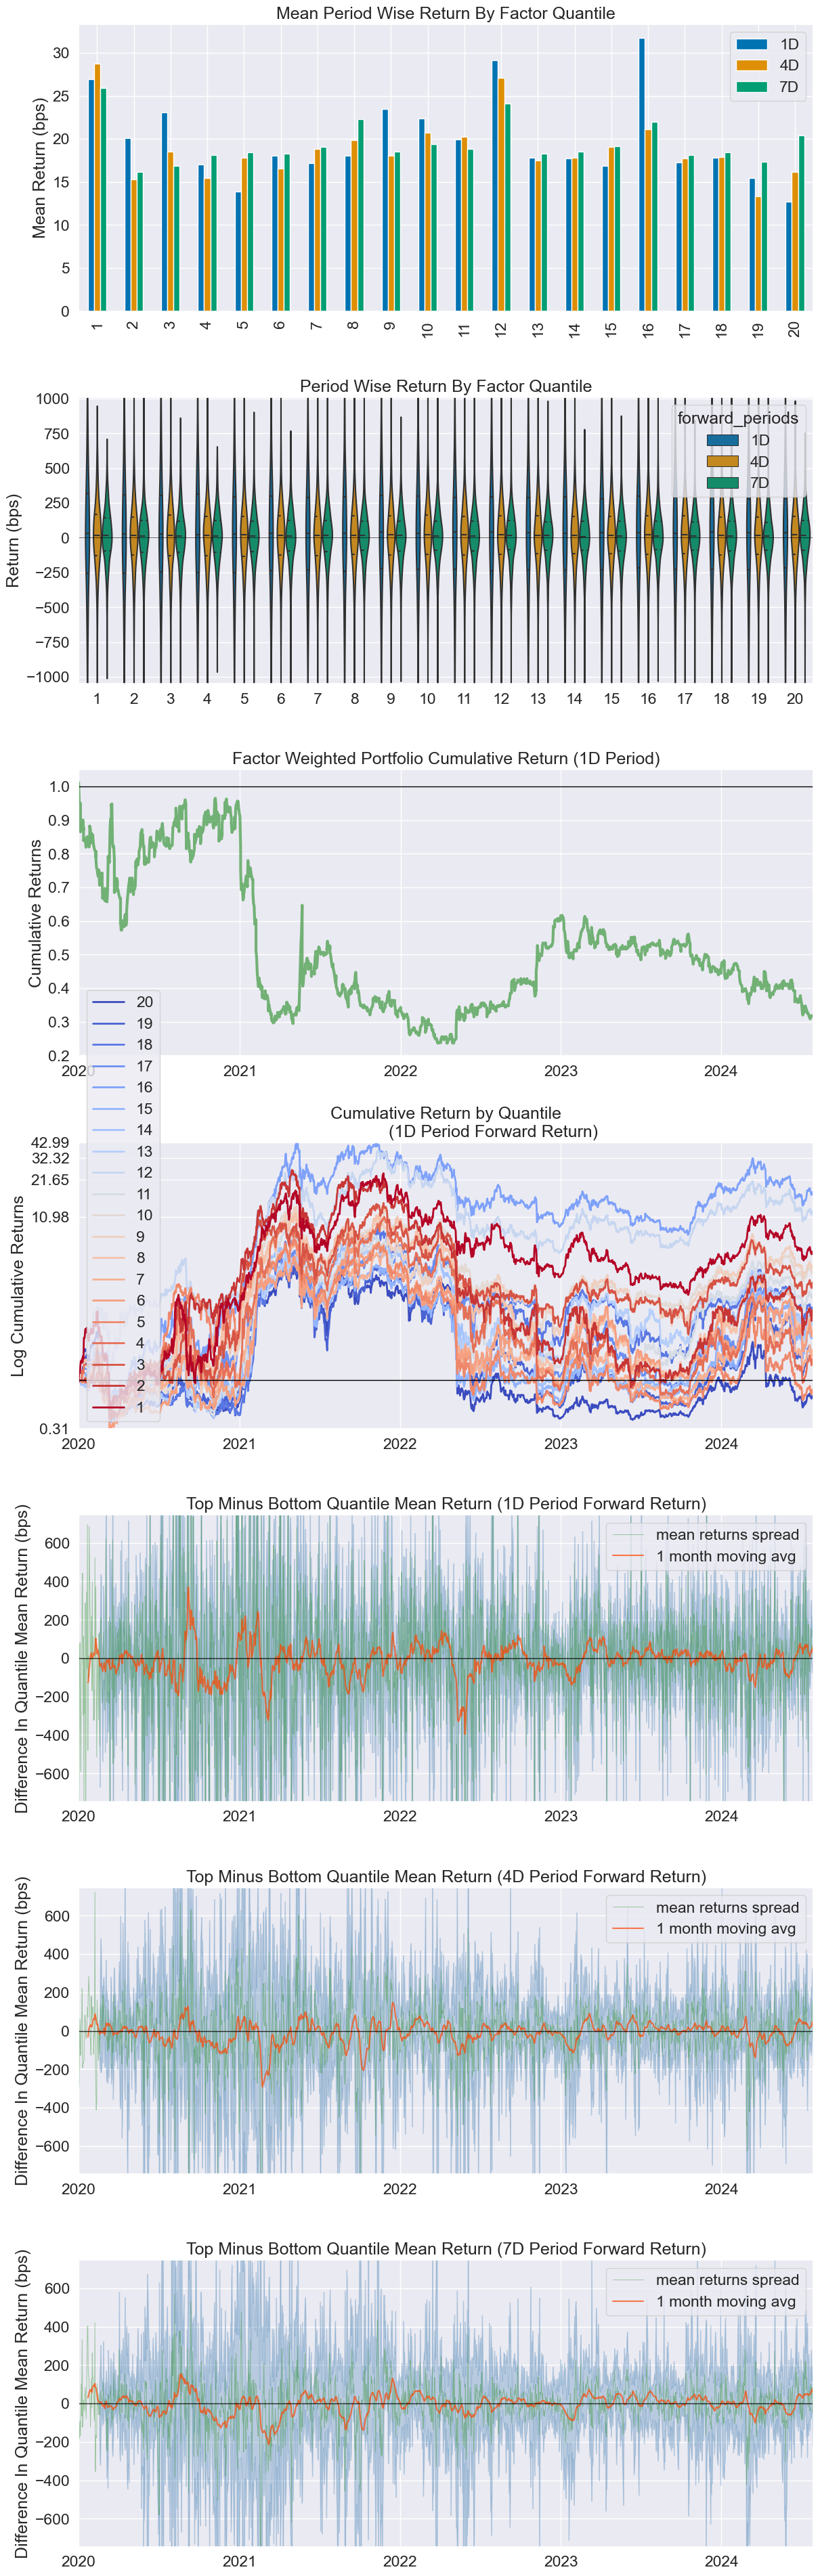

Information Analysis


1D     4D     7D
IC Mean           0.030  0.032  0.035
IC Std.           0.153  0.152  0.155
Risk-Adjusted IC  0.198  0.213  0.229
t-stat(IC)        8.089  8.727  9.377
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.646 -0.297 -0.264
IC Kurtosis       4.474  4.257  4.277

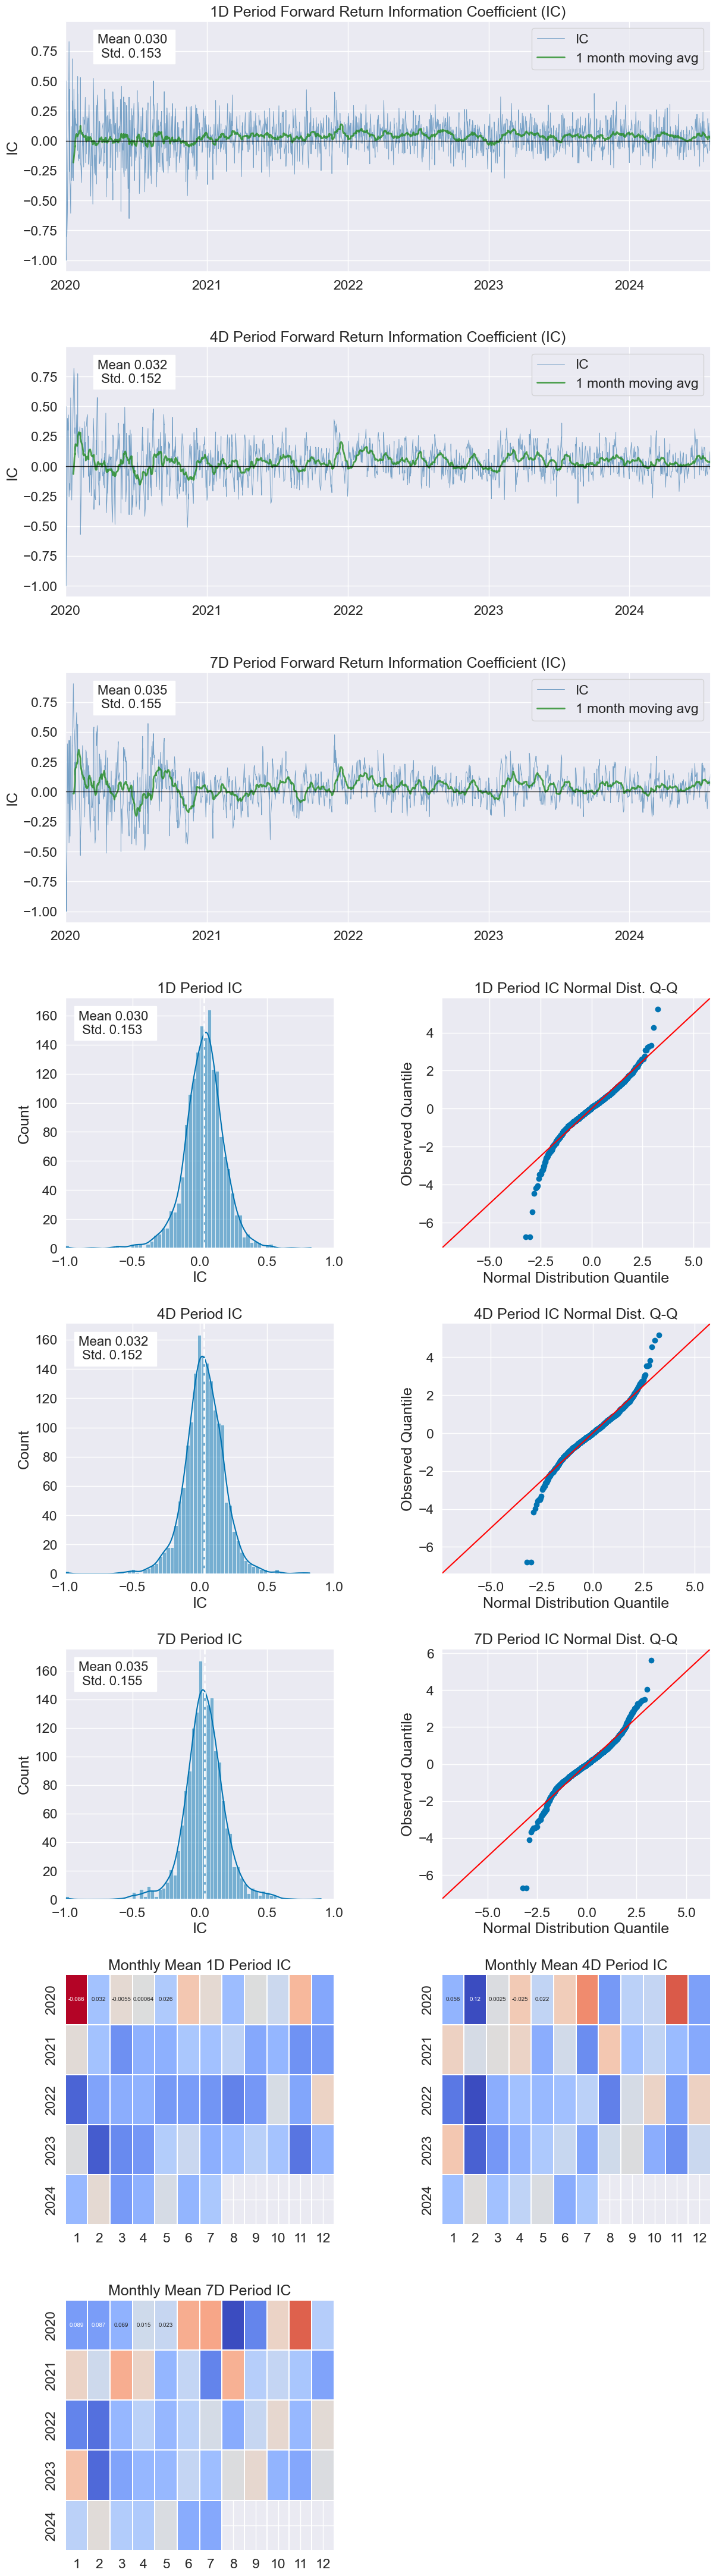

Turnover Analysis


1D     4D     7D
Quantile 1 Mean Turnover    0.489  0.829  0.920
Quantile 2 Mean Turnover    0.753  0.908  0.941
Quantile 3 Mean Turnover    0.822  0.930  0.954
Quantile 4 Mean Turnover    0.852  0.934  0.948
Quantile 5 Mean Turnover    0.866  0.937  0.951
Quantile 6 Mean Turnover    0.888  0.945  0.951
Quantile 7 Mean Turnover    0.884  0.943  0.951
Quantile 8 Mean Turnover    0.899  0.945  0.952
Quantile 9 Mean Turnover    0.902  0.948  0.955
Quantile 10 Mean Turnover   0.897  0.939  0.950
Quantile 11 Mean Turnover   0.908  0.950  0.957
Quantile 12 Mean Turnover   0.901  0.943  0.953
Quantile 13 Mean Turnover   0.899  0.949  0.949
Quantile 14 Mean Turnover   0.884  0.936  0.946
Quantile 15 Mean Turnover   0.884  0.938  0.947
Quantile 16 Mean Turnover   0.878  0.943  0.954
Quantile 17 Mean Turnover   0.866  0.938  0.953
Quantile 18 Mean Turnover   0.834  0.923  0.948
Quantile 19 Mean Turnover   0.780  0.920  0.955
Quantile 20 Mean Turnover   0.546  0.875  0.944

1D     4D     7D
Mean Factor Rank Autocorrelation  0.749  0.287  0.039

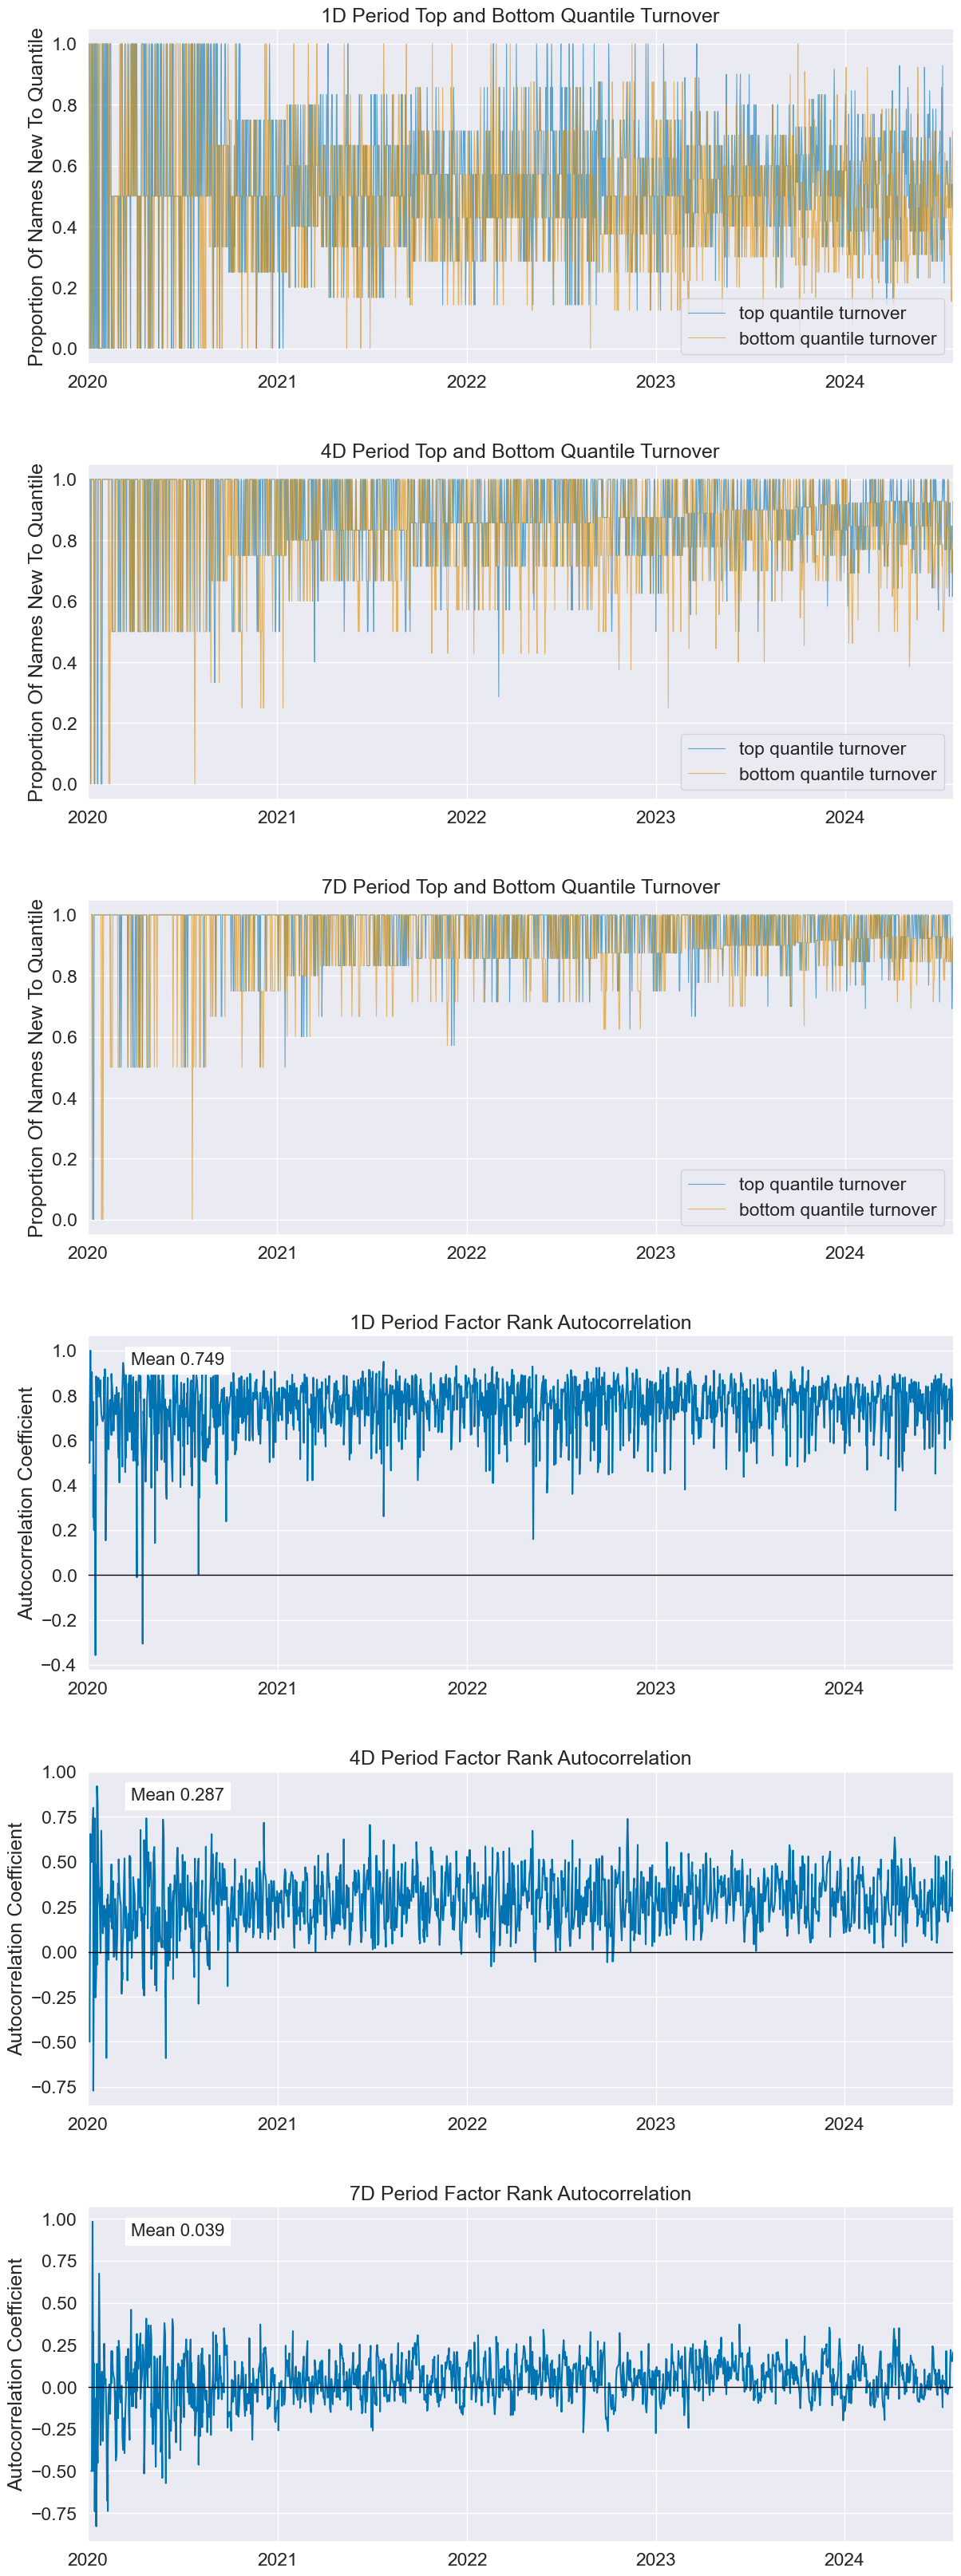

In [47]:
al.tears.create_full_tear_sheet(al_factor_data, long_short=False)